In [41]:
### importing all necessary packages 

import pandas as pd
import numpy as np
import string
import contractions
import re
import nltk
import scipy.sparse as sp
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score,confusion_matrix,recall_score,f1_score 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline, Pipeline

In [42]:
### Loading the data and viewing the top 5 records

data = pd.read_csv('train.csv')
data.head()

,id,comment_text,toxic
0,e617e2489abe9bca,"""\r\n\r\n A barnstar for you! \r\n\r\n The De...",0
1,9250cf637294e09d,"""\r\n\r\nThis seems unbalanced. whatever I ha...",0
2,ce1aa4592d5240ca,"Marya Dzmitruk was born in Minsk, Belarus in M...",0
3,48105766ff7f075b,"""\r\n\r\nTalkback\r\n\r\n Dear Celestia... """,0
4,0543d4f82e5470b6,New Categories \r\n\r\nI honestly think that w...,0


In [43]:
### checking for columns data types. 

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            5000 non-null   object
 1   comment_text  5000 non-null   object
 2   toxic         5000 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 117.3+ KB


In [44]:
# checking for missing values

data.isnull().sum()

id              0
comment_text    0
toxic           0
dtype: int64

In [45]:
# droping the id column

data.drop(['id'], axis=1, inplace=True)
data.head()

,comment_text,toxic
0,"""\r\n\r\n A barnstar for you! \r\n\r\n The De...",0
1,"""\r\n\r\nThis seems unbalanced. whatever I ha...",0
2,"Marya Dzmitruk was born in Minsk, Belarus in M...",0
3,"""\r\n\r\nTalkback\r\n\r\n Dear Celestia... """,0
4,New Categories \r\n\r\nI honestly think that w...,0


##  Data Cleaning

In [46]:
## Extracting all the nltk stopwords.

nltk_stopwords = set(stopwords.words('english'))
list(nltk_stopwords)[1:10]

['haven', 'ma', "you'll", 'don', 'that', "needn't", 'do', 'whom', 're']

In [47]:
## Extracting the sklearn stopwords 

sklearn_stopwords = set(ENGLISH_STOP_WORDS)
list(sklearn_stopwords)[1:10]

['wherever',
 'therefore',
 're',
 'another',
 'keep',
 'somewhere',
 'me',
 'not',
 'sincere']

In [48]:
### Defining Domain specific stop words 

domain_stopwords = ['wikipedia', 'page', 'edit','article','source','editor','people','image','wiki']

In [49]:
# Combining the stopwords from sklearn & NLTK

combined_stopwords = nltk_stopwords.union(sklearn_stopwords)
combined_stopwords = combined_stopwords.union(domain_stopwords)

In [50]:
# Text Normalization: Stemming or Lemmatization (prefer)

lemmatizer = WordNetLemmatizer()

In [51]:
## Defining a cleaner function 

def comment_cleaner(text):
    
    ### remove all ip addresses .
    new_text = re.sub(r'(\d{1,3})\.(\d{1,3})\.(\d{1,3})\.(\d{1,3})',"",text)
    
    ### removing all the hyperlinks
    new_text = re.sub(r"http\S+", "", new_text)
    
    ## Removing all contractions
    new_text = contractions.fix(new_text)  
    
    #### Removing punctuatins
    new_text = new_text.translate(str.maketrans('', '', string.punctuation))
    
    ### Removing numbers
    new_text = re.sub(r'[0-9]',"",new_text)
    
    ## case nomalizing all the words 
    new_text = new_text.lower().strip()
    
    ## removing all the stopwords 
    new_text = [token for token in new_text.split() if token not in combined_stopwords]
    
    ## removing all the words which are of length less than 2 
    new_text = [token for token in new_text if (len(token)>2)] 
    
    ### Lemmatizing all the words using WordNet Lemmatizer .
    cleaned_text = ''
    for token in new_text:
        cleaned_text = cleaned_text + lemmatizer.lemmatize(token) + ' '
        
    return cleaned_text

In [52]:
cleaned_comments = []  # list of cleaned tweets
## creating a list of all cleaned tweets .

for twt in data['comment_text']:
    cleaned_comments.append(comment_cleaner(twt))

cleaned_comments[:5]

['barnstar defender barnstar like kayastha let form solidarity group malign subject matter propose folloing group united intellectual kayastha ethinicty racist castist abuse uifkearca ',
 'unbalanced said mathsci said far extreme unpleasant thing mention greater frequency happy reign like ruth told trying mathsci pay attention stop uncivil expect issue request mathsci intentionally unbalanced reason let know voluntarily close account thing like lot contribute way point contributing project editor administrative leave aggressively rude good really deserve riding as time try certain thing happily leave hand dramaprone think best ludwigs ',
 'marya dzmitruk born minsk belarus march mother olga nikolaevna moroz born baranovichi belarus father born brest belarus second child family parent divorced soon father remarried child marya age began gymnastics quit year later denied medal competition age incorrectly marked turned year old got admitted music school minsk class violin public school pi

In [53]:
### Appending all the cleaned tweets to initial dataframe .

data['cleaned_comments'] = cleaned_comments
data.head()

,comment_text,toxic,cleaned_comments
0,"""\r\n\r\n A barnstar for you! \r\n\r\n The De...",0,barnstar defender barnstar like kayastha let f...
1,"""\r\n\r\nThis seems unbalanced. whatever I ha...",0,unbalanced said mathsci said far extreme unple...
2,"Marya Dzmitruk was born in Minsk, Belarus in M...",0,marya dzmitruk born minsk belarus march mother...
3,"""\r\n\r\nTalkback\r\n\r\n Dear Celestia... """,0,talkback dear celestia
4,New Categories \r\n\r\nI honestly think that w...,0,new category honestly think need add category ...


In [54]:
# Writing a code to collect all the words from all the comments into a single list

all_words = []
for t in data['cleaned_comments']:
    all_words.extend(t.split())

print(all_words[:50])
len(set(all_words)) # this is the number of unique words in the list

['barnstar', 'defender', 'barnstar', 'like', 'kayastha', 'let', 'form', 'solidarity', 'group', 'malign', 'subject', 'matter', 'propose', 'folloing', 'group', 'united', 'intellectual', 'kayastha', 'ethinicty', 'racist', 'castist', 'abuse', 'uifkearca', 'unbalanced', 'said', 'mathsci', 'said', 'far', 'extreme', 'unpleasant', 'thing', 'mention', 'greater', 'frequency', 'happy', 'reign', 'like', 'ruth', 'told', 'trying', 'mathsci', 'pay', 'attention', 'stop', 'uncivil', 'expect', 'issue', 'request', 'mathsci', 'intentionally']


21226

##  Data Visualisation

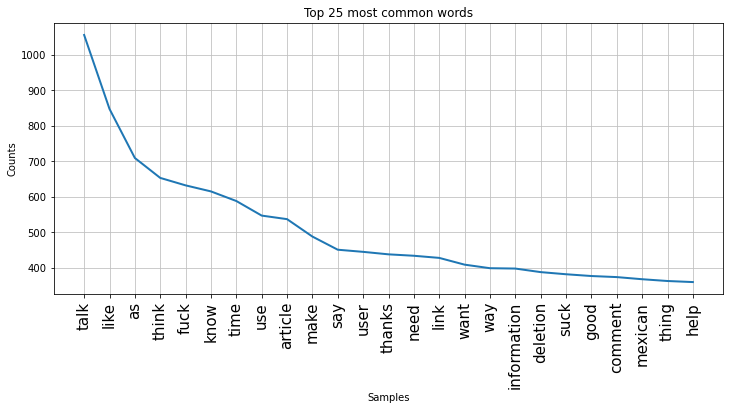

In [55]:
## Frequency Distribution

freq_dist = nltk.FreqDist(all_words)

## Visualizing all the top 25 frequently used .

plt.figure(figsize=(12,5))
plt.title('Top 25 most common words')
plt.xticks(fontsize=15)

freq_dist.plot(25, cumulative=False)

plt.show()

## TF-IDF Vectorizer 

In [56]:
### Viewing the data

data.head()

,comment_text,toxic,cleaned_comments
0,"""\r\n\r\n A barnstar for you! \r\n\r\n The De...",0,barnstar defender barnstar like kayastha let f...
1,"""\r\n\r\nThis seems unbalanced. whatever I ha...",0,unbalanced said mathsci said far extreme unple...
2,"Marya Dzmitruk was born in Minsk, Belarus in M...",0,marya dzmitruk born minsk belarus march mother...
3,"""\r\n\r\nTalkback\r\n\r\n Dear Celestia... """,0,talkback dear celestia
4,New Categories \r\n\r\nI honestly think that w...,0,new category honestly think need add category ...


In [57]:
### dividing the data into feaures and labels and splitting the data into train and test.

X = data['cleaned_comments']
y = data['toxic']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, stratify=data['toxic'], random_state=42)

In [58]:
###  Initiating the vectorizer with 4000 maximum features and extracting features for X_train and X_test.

Tf = TfidfVectorizer(max_features=4000)
Tf_X_train = Tf.fit_transform(X_train)
Tf_X_test=Tf.transform(X_test)

In [59]:
## Viewig the type and size of both train and test feature matrix created .

type(Tf_X_train),type(Tf_X_test),Tf_X_train.shape,Tf_X_test.shape

(scipy.sparse.csr.csr_matrix,
 scipy.sparse.csr.csr_matrix,
 (3500, 4000),
 (1500, 4000))

##  Model Building 

In [60]:
### viewing the ratio of 0's and 1's in given dataset.

data['toxic'].value_counts(normalize=True)

0    0.9126
1    0.0874
Name: toxic, dtype: float64

In [61]:
### viewing the ratio of 0's and 1's in train set after split.

y_train.value_counts(normalize=True)

0    0.912571
1    0.087429
Name: toxic, dtype: float64

In [62]:
#### Viewing the split of 0's and 1's in test set after split. 

y_test.value_counts(normalize=True)

0    0.912667
1    0.087333
Name: toxic, dtype: float64

In [63]:
### Train the a model using SVC algorithm .
### LinearSVC performs better than SVC with linear kernel , eventough both of them have lineaar boundaries , so LinearSVC is
### used for model building . 

clf = LinearSVC()
clf.fit(Tf_X_train,y_train)
print("Train Score :",clf.score(Tf_X_train, y_train))
print("Test Score : ",clf.score(Tf_X_test,y_test))

Train Score : 0.994
Test Score :  0.9473333333333334


In [64]:
#### Making prediction for test and calculating metrics 

y_pred=clf.predict(Tf_X_test)
print("Accuracy Score : " ,accuracy_score(y_pred,y_test))
print("Recall Score : ", recall_score(y_pred,y_test))
print("F1_score : " ,f1_score(y_pred,y_test))

Accuracy Score :  0.9473333333333334
Recall Score :  0.8823529411764706
F1_score :  0.6030150753768845


####  Here recall is high

<AxesSubplot:>

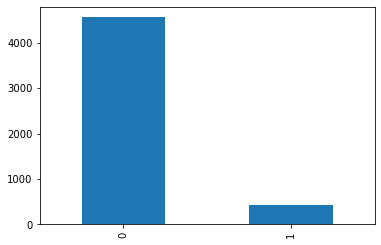

In [65]:
# plot the toxic/non-toxic comment counts 

data['toxic'].value_counts().plot(kind='bar')

In [66]:
### Training an model using SVC Classifier with class_weight balanced option since there is class imbalance in the dataset .

clf2 = LinearSVC(class_weight='balanced')
clf2.fit(Tf_X_train,y_train)
print("Train Score :",clf2.score(Tf_X_train, y_train))
print("Test Score : ",clf2.score(Tf_X_test,y_test))



Train Score : 0.992
Test Score :  0.9306666666666666


In [67]:
#### Making prediction for test and calculating metrics 

y_pred=clf2.predict(Tf_X_test)
print("Accuracy Score : " ,accuracy_score(y_pred,y_test))
print("Recall Score : ", recall_score(y_pred,y_test))
print("F1_score : " ,f1_score(y_pred,y_test))

Accuracy Score :  0.9306666666666666
Recall Score :  0.6115702479338843
F1_score :  0.5873015873015873


#### Here the recall is not so high as 'clf' model

In [68]:
### Appending train feature set and test feature set 

X = sp.vstack((Tf_X_train,Tf_X_test))  

In [69]:
## Hyper parameter tuning of the clf2 model


C_values = np.arange(0.00001, 1, 0.05) # 20 values

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(estimator=clf2, param_grid={'C': C_values}, cv=kfold, \
                    return_train_score=True, verbose=2, n_jobs=-1)
grid_results = grid.fit(X,y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [70]:
### Viewing the results 

grid_results

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LinearSVC(class_weight='balanced'), n_jobs=-1,
             param_grid={'C': array([1.0000e-05, 5.0010e-02, 1.0001e-01, 1.5001e-01, 2.0001e-01,
       2.5001e-01, 3.0001e-01, 3.5001e-01, 4.0001e-01, 4.5001e-01,
       5.0001e-01, 5.5001e-01, 6.0001e-01, 6.5001e-01, 7.0001e-01,
       7.5001e-01, 8.0001e-01, 8.5001e-01, 9.0001e-01, 9.5001e-01])},
             return_train_score=True, verbose=2)

In [71]:
### Viewing the best parameter . 

grid_results.best_params_, grid_results.best_score_, grid_results.best_index_

({'C': 0.95001}, 0.8178000000000001, 19)

In [72]:
### Finding the best estimator using cross validation and best parameter identified above using 'recall' as scoring method .


clf3 = LinearSVC(class_weight='balanced', C=0.95)

results = cross_validate(clf3,X,y , cv=kfold, scoring='recall')

clf3.fit(Tf_X_train,y_train)

y_pred=clf3.predict(Tf_X_test)

print("Train Score :",clf3.score(Tf_X_train, y_train))
print("Test Score : ",clf3.score(Tf_X_test,y_test))
print("Accuracy Score : " ,accuracy_score(y_pred,y_test))
print("Recall Score : ", recall_score(y_pred,y_test))
print("F1_score : " ,f1_score(y_pred,y_test))

Train Score : 0.9917142857142857
Test Score :  0.9306666666666666
Accuracy Score :  0.9306666666666666
Recall Score :  0.6115702479338843
F1_score :  0.5873015873015873


#### Here the recall score is not so high as 'clf' model,its same as of 'clf2' model

In [73]:
##### Creating a pipeline , so that all the steps in model building can be done without any dataleakage .

X = data['cleaned_comments']
y = data['toxic']

Tf = TfidfVectorizer(max_features=4000)
clf4 = LinearSVC(class_weight='balanced', C=0.95)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, stratify=data['toxic'], random_state=42)

CV_pipe = Pipeline([('Tf', Tf) , ('clf4', clf4)] )

results = cross_val_score(CV_pipe, X, y, cv=kfold, scoring='recall')


CV_pipe.fit(X_train,y_train)

### making predictions for test set using pipeline created and calculating all the metrics .

y_pred=CV_pipe.predict(X_test)

print("Train Score :",CV_pipe.score(X_train, y_train))
print("Test Score : ",CV_pipe.score(X_test,y_test))
print("Accuracy Score : " ,accuracy_score(y_pred,y_test))
print("Recall Score : ", recall_score(y_pred,y_test))
print("F1_score : " ,f1_score(y_pred,y_test))


Train Score : 0.9917142857142857
Test Score :  0.9306666666666666
Accuracy Score :  0.9306666666666666
Recall Score :  0.6115702479338843
F1_score :  0.5873015873015873


#### Here the recall score is not so high as 'clf' model,its same as of 'clf2' model and 'clf3' model

In [74]:
#### creating a DataFrame which contains test comments set and its predictions made by the model 

df = pd.DataFrame()
df['comments_test'] = X_test
df['comment'] = y_pred

In [75]:
### setting the index for the created dataframe.

id_values = np.arange(1, 1501, 1)
df.set_index(id_values,inplace=True)

In [76]:
### creating the temporary dataframe which contains only toxic comments.

temp_df = df[df['comment'] == 1]['comments_test']

In [77]:
### creating a list of all words present in the toxic comments .

all_words = []
for t in temp_df:
    all_words.extend(t.split())

print(all_words[:50])
len(set(all_words))  ### total number of words presents in all toxic comments .

['halo', 'glitch', 'make', 'halo', 'glitch', 'like', 'glitch', 'high', 'charity', 'begin', 'level', 'bullet', 'covenant', 'carbine', 'maximum', 'bullet', 'carbine', 'redneck', 'bad', 'mouth', 'nascar', 'think', 'god', 'site', 'act', 'like', 'nazi', 'masterbate', 'hand', 'stroking', 'unit', 'think', 'block', 'work', 'better', 'god', 'stupid', 'deletion', 'hey', 'delete', 'mofo', 'psychological', 'problem', 'advice', 'dude', 'looking', 'extensive', 'history', 'want', 'share']


957

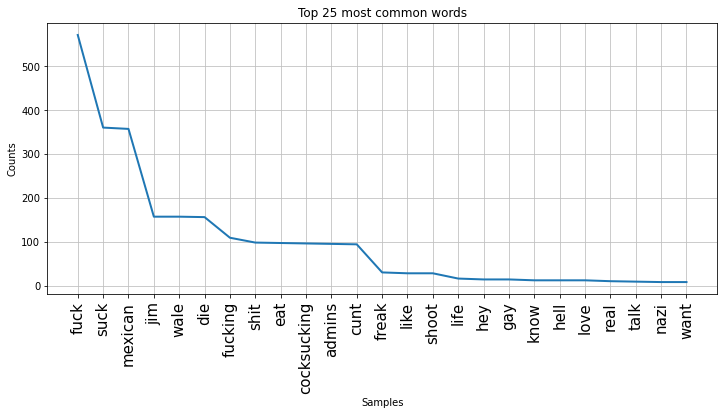

In [78]:
## Frequency Distribution

freq_dist = nltk.FreqDist(all_words)

## Visualizing all the top 25 frequently used .

plt.figure(figsize=(12,5))
plt.title('Top 25 most common words')
plt.xticks(fontsize=15)

freq_dist.plot(25, cumulative=False)

plt.show()